In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import gc
from tqdm.notebook import tqdm
from collections import deque

import torch
from torch.optim import AdamW
from torch.utils.data import DataLoader

from datasets import Dataset

from transformers import AutoTokenizer, GPT2LMHeadModel, set_seed

from src.config import Config
from src.dataset2 import SBICDataset

CONFIG:Config = Config()
set_seed(CONFIG.seed)

2023-10-01 12:44:44.168351: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 12:44:44.903310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_pickle(CONFIG.dataset.train_data_raw)
df.head()

,whoTarget,intentYN,sexYN,offensiveYN,speakerMinorityYN,post,targetMinority,targetCategory,targetStereotype,dataSource
0,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
1,0.0,1.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
2,0.0,0.0,0.0,1.0,0.0,RT @_LexC__: I'm convinced that some of y'all ...,,,,t/davidson
3,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,all stupid,t/davidson
4,1.0,1.0,0.0,1.0,0.0,RT @iBeZo: Stupid fucking nigger LeBron. You f...,black folks,race,are not people but apes.,t/davidson


In [4]:
tokenizer = AutoTokenizer.from_pretrained('distilgpt2',
                                          padding_side="left")
model = GPT2LMHeadModel.from_pretrained('distilgpt2')

tokenizer.add_special_tokens(CONFIG.train_params.special_tokens)
print("List of all special token and its token_id:")
print(" -", tokenizer.all_special_tokens)
print(" -",tokenizer(tokenizer.all_special_tokens)["input_ids"])
print("Model vocab size pre resize:", model.config.vocab_size)
model.resize_token_embeddings(len(tokenizer))
# print("Model vocab size post resize:", model.config.vocab_size)
model.config.pad_token_id = tokenizer.pad_token_id
model.config.sep_token_id = tokenizer.sep_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.bos_token_id = tokenizer.bos_token_id
print("Model pad token:", model.config.pad_token_id)
print("Model sep token:", model.config.sep_token_id)

model.generation_config.max_new_tokens=50

List of all special token and its token_id:
 - ['[BOS]', '<|endoftext|>', '[SEP]', '<|pad|>', '[offY]', '[offN]', '[sexY]', '[sexN]', '[intY]', '[intN]', '[grpY]', '[grpN]', '[ingrpN]', '[ingrpY]']
 - [[50258], [50256], [50259], [50257], [50260], [50261], [50262], [50263], [50264], [50265], [50266], [50267], [50268], [50269]]
Model vocab size pre resize: 50257
Model pad token: 50257
Model sep token: 50259


In [5]:
train_data = pd.read_pickle(CONFIG.dataset.train_data_raw).to_numpy()[4:5]
# val_data = pd.read_pickle(CONFIG.dataset.val_data_raw).to_numpy()[:100]

train_dataset = SBICDataset(train_data, tokenizer, max_sequence_length=256)
# val_dataset = SBICDataset(val_data, tokenizer, CONFIG.utils.class_label_encoder)

train_loader = DataLoader(train_dataset, batch_size=1, drop_last=False, shuffle=True, pin_memory=True)
# val_loader   = DataLoader(val_dataset,   batch_size=CONFIG.train_params.batch_size, drop_last=False, shuffle=True, pin_memory=True)

In [6]:
# model = GPT2LMHeadModel.from_pretrained('gpt2')
model.to(CONFIG.train_params.device)

optimizer = AdamW(model.parameters(), lr=1e-4)

total_loss = 0
epochs = 200
loss_epochs = deque(maxlen=epochs)

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for n_iter, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # for n_iter, batch in enumerate(tqdm(train_loader, total=len(train_loader))):
        inputs = {k: v.to(CONFIG.train_params.device) for k, v in batch.items()}
        
        # model.zero_grad()

        # print(inputs)
        # # print(tokenizer.batch_decode(inputs["input_ids"]))
        # # raise
        # # print(tokenizer.batch_decode(inputs["labels"]))
        # raise
            
        # Forward pass
        outputs = model(input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"],
                        labels = inputs["labels"] )
        loss, logit = outputs[:2]

        total_loss += loss.item()

        if n_iter % 10 == 0:
            print(f"Epoch {epoch}: loss = {loss.item()} iteration n°{n_iter+1}")
        
        # Backward pass
        loss.backward()
        loss_epochs.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
                
        # gc.collect()

    avg_epoch_loss = total_loss / len(train_loader)

gc.collect
torch.cuda.empty_cache()

Epoch 0: loss = 5.8550262451171875 iteration n°1
Epoch 1: loss = 26.487558364868164 iteration n°1
Epoch 2: loss = 24.06024932861328 iteration n°1
Epoch 3: loss = 10.827789306640625 iteration n°1
Epoch 4: loss = 9.218735694885254 iteration n°1
Epoch 5: loss = 5.231975078582764 iteration n°1
Epoch 6: loss = 4.920854568481445 iteration n°1
Epoch 7: loss = 3.861722946166992 iteration n°1
Epoch 8: loss = 11.903945922851562 iteration n°1
Epoch 9: loss = 4.009267330169678 iteration n°1
Epoch 10: loss = 5.181119918823242 iteration n°1
Epoch 11: loss = 2.4630281925201416 iteration n°1
Epoch 12: loss = 4.9003586769104 iteration n°1
Epoch 13: loss = 2.5303843021392822 iteration n°1
Epoch 14: loss = 3.999861717224121 iteration n°1
Epoch 15: loss = 2.8233001232147217 iteration n°1
Epoch 16: loss = 2.4765937328338623 iteration n°1
Epoch 17: loss = 4.993722438812256 iteration n°1
Epoch 18: loss = 2.756657361984253 iteration n°1
Epoch 19: loss = 2.137151002883911 iteration n°1
Epoch 20: loss = 2.05045

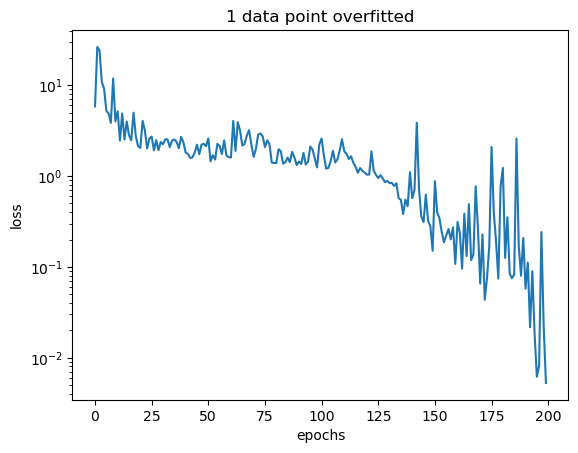

In [7]:
import matplotlib.pyplot as plt

plt.semilogy(loss_epochs)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("1 data point overfitted")
plt.show()

In [8]:
model.train()
# model.to(CONFIG.train_params.device)

post = "Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot." + "[SEP][offY][intN][sexN][ingrpY]<|endoftext|>"
# post = "what is the capital of USA?"
# inputs_str = tokenizer.bos_token + post + tokenizer.sep_token
# inputs_str = "post: " + post + "\n"
# next_token = "offensive:"

inputs = tokenizer(post, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
# inputs["labels"] = inputs["input_ids"]
labels = tokenizer(
    "[SEP][offY][intN][sexN][ingrpY]<|endoftext|>", return_tensors="pt", truncation=True, padding="max_length", max_length=256,
)["input_ids"]
print(labels)
inputs["labels"] = torch.where(labels == tokenizer.pad_token_id, -100, labels).long()
print("labels", inputs["labels"][0][1:])


# print(inputs["input_ids"].shape)
# print(inputs["labels"].shape)


inputs = {k: v.to(CONFIG.train_params.device) for k, v in inputs.items()}

outputs = model(**inputs)

logits = torch.argmax(outputs.logits[0, :-1, :], axis=-1)

print("logits", logits[:-1])
# print(inputs)
# print(logits)
print(outputs.loss)

# print(outputs.logits.shape)
# 
print(logits.shape)


out_str = tokenizer.decode(logits)


print("input:", post)
print("output:", out_str)

tensor([[50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 5